## 1. Imports & global config

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Global simulation parameters
DT = 0.01              # Fixed time step for sampling
T_TOTAL = 500.0        # Total simulation time (yields ~50k points)
N_TRANSIENT = 2000     # Number of initial transient points to discard

# Matplotlib defaults for better readability
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.autolayout'] = True

print(f"Configuration loaded:")
print(f"  dt = {DT}, T_total = {T_TOTAL}")
print(f"  Expected points before transient removal: {int(T_TOTAL / DT)}")
print(f"  Transient removal: {N_TRANSIENT} points")

Configuration loaded:
  dt = 0.01, T_total = 500.0
  Expected points before transient removal: 50000
  Transient removal: 2000 points


## 2. Lorenz simulator

In [ ]:
def simulate_lorenz(rho, sigma=10.0, beta=8.0/3.0, 
                   x0=np.array([1.0, 1.0, 1.0]), 
                   dt=0.01, t_final=100.0, n_transient=2000):
    """
    Simulate the Lorenz system at fixed time steps.
    
    Parameters
    ----------
    rho : float
        Lorenz parameter ρ (controls chaotic behavior).
    sigma : float, optional
        Lorenz parameter σ (default 10.0).
    beta : float, optional
        Lorenz parameter β (default 8/3).
    x0 : array_like, shape (3,)
        Initial condition [x, y, z].
    dt : float, optional
        Fixed sampling time step.
    t_final : float, optional
        Total simulation time.
    n_transient : int, optional
        Number of initial points to discard as transient.
    
    Returns
    -------
    t : ndarray, shape (N,)
        Time array after transient removal.
    X : ndarray, shape (N, 3)
        Trajectory in phase space, columns are [x, y, z].
    """
    
    def lorenz_rhs(t, state):
        """Right-hand side of Lorenz ODEs."""
        x, y, z = state
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return [dx, dy, dz]
    
    # Create dense time grid for fixed-step sampling
    t_eval = np.arange(0, t_final, dt)
    
    # Integrate using solve_ivp with adaptive stepping internally,
    # but evaluate at fixed points
    sol = solve_ivp(
        lorenz_rhs, 
        t_span=(0, t_final), 
        y0=x0, 
        t_eval=t_eval,
        method='RK45',
        rtol=1e-8,
        atol=1e-10
    )
    
    # Transpose to get (time, state_dim) shape
    X_full = sol.y.T  # shape: (len(t_eval), 3)
    t_full = sol.t
    
    # Discard transient
    t = t_full[n_transient:]
    X = X_full[n_transient:, :]
    
    return t, X

# Quick test
t_test, X_test = simulate_lorenz(rho=28, dt=DT, t_final=10.0, n_transient=500)
print(f"Simulator test: generated {len(t_test)} points, X.shape = {X_test.shape}")

Simulator test: generated 500 points, X.shape = (500, 3)


## 3. Generate datasets (chaotic vs non-chaotic)

In [ ]:
# Same initial condition for both regimes
x0_common = np.array([1.0, 1.0, 1.0])

# Chaotic regime: rho = 28
print("Generating chaotic dataset (rho=28)...")
t_chaos, X_chaos_raw = simulate_lorenz(
    rho=28.0, 
    sigma=10.0, 
    beta=8.0/3.0,
    x0=x0_common,
    dt=DT,
    t_final=T_TOTAL,
    n_transient=N_TRANSIENT
)
print(f"  Chaotic: {X_chaos_raw.shape[0]} points after transient removal")

# Non-chaotic regime: rho = 10 (two stable fixed points)
print("Generating non-chaotic dataset (rho=10)...")
t_nonchaos, X_nonchaos_raw = simulate_lorenz(
    rho=10.0, 
    sigma=10.0, 
    beta=8.0/3.0,
    x0=x0_common,
    dt=DT,
    t_final=T_TOTAL,
    n_transient=N_TRANSIENT
)
print(f"  Non-chaotic: {X_nonchaos_raw.shape[0]} points after transient removal")

# Standardize for EDMD (zero mean, unit variance per coordinate)
# Keep raw copies for plotting
scaler_chaos = StandardScaler()
X_chaos = scaler_chaos.fit_transform(X_chaos_raw)

scaler_nonchaos = StandardScaler()
X_nonchaos = scaler_nonchaos.fit_transform(X_nonchaos_raw)

print(f"\nStandardization complete.")
print(f"  Chaos mean: {X_chaos.mean(axis=0)}, std: {X_chaos.std(axis=0)}")
print(f"  Non-chaos mean: {X_nonchaos.mean(axis=0)}, std: {X_nonchaos.std(axis=0)}")

Generating chaotic dataset (rho=28)...
  Chaotic: 48000 points after transient removal
Generating non-chaotic dataset (rho=10)...
  Non-chaotic: 48000 points after transient removal

Standardization complete.
  Chaos mean: [ 9.47390314e-18 -7.10542736e-18 -8.18308384e-16], std: [1. 1. 1.]
  Non-chaos mean: [ 5.16363055e-10 -5.79282156e-10 -4.61775403e-10], std: [1. 1. 1.]


## 4. Quick visualization of trajectories

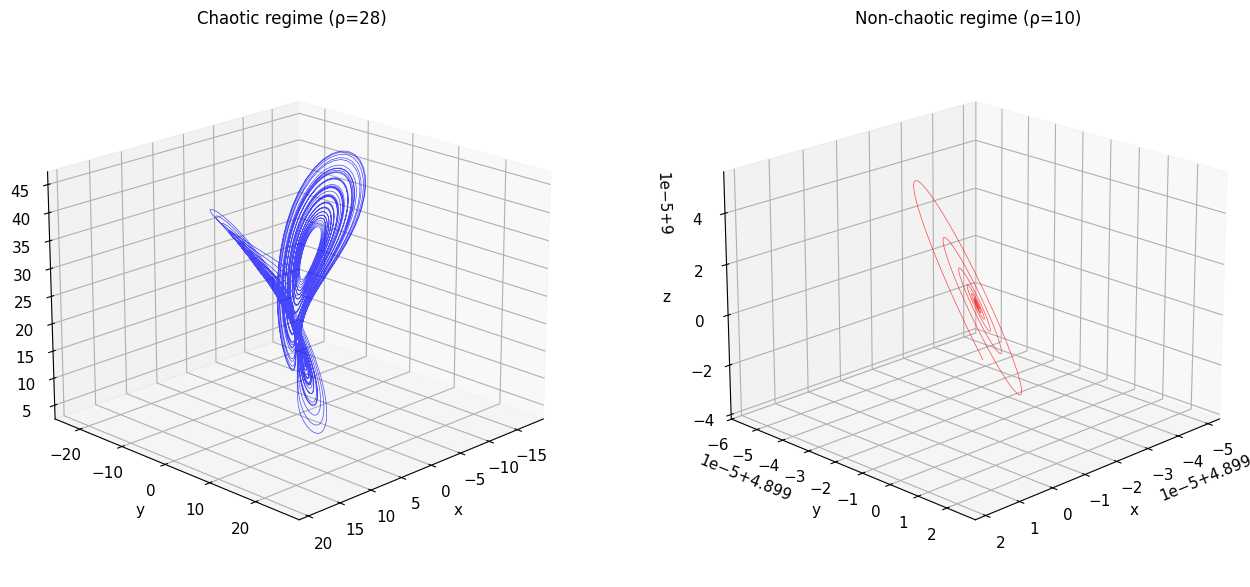

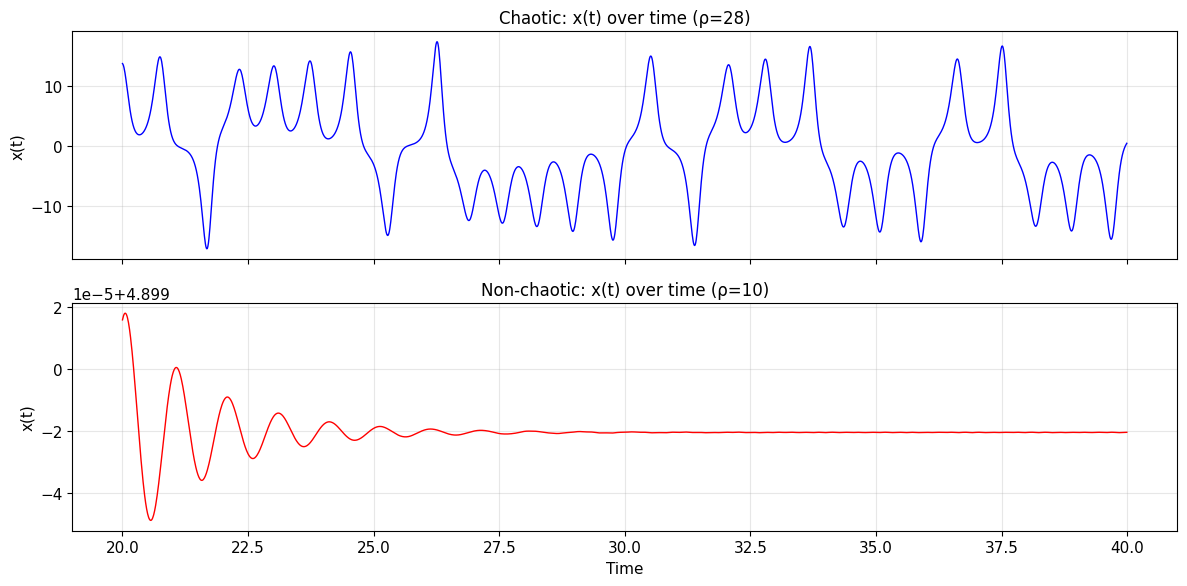

In [ ]:
# 3D phase portraits
fig = plt.figure(figsize=(14, 6))

# Chaotic
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(X_chaos_raw[:5000, 0], X_chaos_raw[:5000, 1], X_chaos_raw[:5000, 2], 
         'b-', linewidth=0.5, alpha=0.7)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Chaotic regime (ρ=28)')
ax1.view_init(elev=20, azim=45)

# Non-chaotic
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(X_nonchaos_raw[:5000, 0], X_nonchaos_raw[:5000, 1], X_nonchaos_raw[:5000, 2], 
         'r-', linewidth=0.5, alpha=0.7)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Non-chaotic regime (ρ=10)')
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# Time series of x-coordinate
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

window_size = 2000  # Show first 2000 points (20 time units)

# Chaotic
axes[0].plot(t_chaos[:window_size], X_chaos_raw[:window_size, 0], 'b-', linewidth=1)
axes[0].set_ylabel('x(t)')
axes[0].set_title('Chaotic: x(t) over time (ρ=28)')
axes[0].grid(True, alpha=0.3)

# Non-chaotic
axes[1].plot(t_nonchaos[:window_size], X_nonchaos_raw[:window_size, 0], 'r-', linewidth=1)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('x(t)')
axes[1].set_title('Non-chaotic: x(t) over time (ρ=10)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Build EDMD dictionary (polynomial features)

In [ ]:
def poly_features(X, degree=2, include_constant=True):
    """
    Build polynomial feature dictionary for EDMD.
    
    Generates all monomials in (x, y, z) up to given degree, including
    cross terms (e.g., x*y, x^2*y, etc.).
    
    Parameters
    ----------
    X : ndarray, shape (N, 3)
        Input data with 3 coordinates.
    degree : int, optional
        Maximum polynomial degree (default 2).
    include_constant : bool, optional
        Whether to include constant feature (default True).
    
    Returns
    -------
    Psi : ndarray, shape (N, M)
        Lifted feature matrix with M features.
    feature_names : list of str
        Human-readable names of features.
    """
    N = X.shape[0]
    features = []
    feature_names = []
    
    # Constant term
    if include_constant:
        features.append(np.ones(N))
        feature_names.append('1')
    
    # Generate all monomials up to degree
    # For 3 variables (x, y, z), iterate over powers (i, j, k)
    # such that i + j + k <= degree and i + j + k > 0
    for d in range(1, degree + 1):
        for i in range(d + 1):
            for j in range(d + 1 - i):
                k = d - i - j
                if k >= 0:
                    # Compute x^i * y^j * z^k
                    feature = (X[:, 0]**i) * (X[:, 1]**j) * (X[:, 2]**k)
                    features.append(feature)
                    
                    # Build name
                    terms = []
                    if i > 0:
                        terms.append(f'x^{i}' if i > 1 else 'x')
                    if j > 0:
                        terms.append(f'y^{j}' if j > 1 else 'y')
                    if k > 0:
                        terms.append(f'z^{k}' if k > 1 else 'z')
                    feature_names.append('*'.join(terms))
    
    Psi = np.column_stack(features)
    return Psi, feature_names

# Test the dictionary builder
Psi_test, names_test = poly_features(X_chaos[:10], degree=2, include_constant=True)
print(f"Polynomial dictionary test (degree=2, include_constant=True):")
print(f"  Input shape: (10, 3)")
print(f"  Output shape: {Psi_test.shape}")
print(f"  Number of features: {len(names_test)}")
print(f"  Feature names: {names_test}")

Polynomial dictionary test (degree=2, include_constant=True):
  Input shape: (10, 3)
  Output shape: (10, 10)
  Number of features: 10
  Feature names: ['1', 'z', 'y', 'x', 'z^2', 'y*z', 'y^2', 'x*z', 'x*y', 'x^2']


## 6. EDMD fit (one-step map in lifted space)

In [ ]:
def fit_edmd(X, degree=2, include_constant=True, ridge=1e-8):
    """
    Fit EDMD operator K via least squares in lifted polynomial space.
    
    Given time series X = [x_0, ..., x_{T-1}], construct:
      - Ψ   = ψ(X[:-1])  (snapshots at t)
      - Ψ'  = ψ(X[1:])   (snapshots at t+1)
    
    Solve: K = argmin_K ||Ψ' - K Ψ||_F^2 + ridge * ||K||_F^2
    
    Parameters
    ----------
    X : ndarray, shape (N, 3)
        Time series data (already standardized).
    degree : int, optional
        Polynomial degree for dictionary.
    include_constant : bool, optional
        Include constant feature.
    ridge : float, optional
        Tikhonov regularization parameter (default 1e-8).
    
    Returns
    -------
    K : ndarray, shape (M, M)
        EDMD operator in lifted space.
    Psi : ndarray, shape (N-1, M)
        Lifted snapshots at time t.
    Psi_next : ndarray, shape (N-1, M)
        Lifted snapshots at time t+1.
    feature_names : list of str
        Feature names.
    """
    # Build snapshot pairs
    X_current = X[:-1, :]   # t = 0, ..., T-2
    X_next = X[1:, :]       # t = 1, ..., T-1
    
    # Lift to polynomial space
    Psi, feature_names = poly_features(X_current, degree=degree, 
                                       include_constant=include_constant)
    Psi_next, _ = poly_features(X_next, degree=degree, 
                                include_constant=include_constant)
    
    M = Psi.shape[1]  # Number of lifted features
    
    # Solve K: Ψ' ≈ K Ψ using least squares
    # We solve: Ψ'.T ≈ Ψ.T @ K.T, then transpose back
    # With Tikhonov: (Ψ.T @ Ψ + ridge * I) @ K.T = Ψ.T @ Ψ'.T
    
    # Compute Gram matrix with regularization
    G = Psi.T @ Psi + ridge * np.eye(M)
    C = Psi.T @ Psi_next
    
    # Solve for K.T
    K_T = np.linalg.solve(G, C)
    K = K_T.T
    
    print(f"EDMD fit complete:")
    print(f"  Data points: {X.shape[0]}, Snapshot pairs: {Psi.shape[0]}")
    print(f"  Lifted dimension: {M}")
    print(f"  K shape: {K.shape}")
    print(f"  Ridge parameter: {ridge}")
    
    return K, Psi, Psi_next, feature_names

# Fit EDMD for both datasets with degree=2
print("=" * 60)
print("Fitting EDMD for CHAOTIC regime:")
print("=" * 60)
K_chaos, Psi_chaos, Psi_chaos_next, feat_names = fit_edmd(
    X_chaos, degree=2, include_constant=True, ridge=1e-8
)

print("\n" + "=" * 60)
print("Fitting EDMD for NON-CHAOTIC regime:")
print("=" * 60)
K_nonchaos, Psi_nonchaos, Psi_nonchaos_next, _ = fit_edmd(
    X_nonchaos, degree=2, include_constant=True, ridge=1e-8
)

Fitting EDMD for CHAOTIC regime:
EDMD fit complete:
  Data points: 48000, Snapshot pairs: 47999
  Lifted dimension: 10
  K shape: (10, 10)
  Ridge parameter: 1e-08

Fitting EDMD for NON-CHAOTIC regime:
EDMD fit complete:
  Data points: 48000, Snapshot pairs: 47999
  Lifted dimension: 10
  K shape: (10, 10)
  Ridge parameter: 1e-08


## 7. Define EDMD losses

In [ ]:
def compute_edmd_loss(K, Psi, Psi_next):
    """
    Compute normalized one-step EDMD loss.
    
    L_EDMD = ||Ψ' - K Ψ||_F^2 / ||Ψ'||_F^2
    
    Parameters
    ----------
    K : ndarray, shape (M, M)
        EDMD operator.
    Psi : ndarray, shape (N, M)
        Lifted snapshots at time t.
    Psi_next : ndarray, shape (N, M)
        Lifted snapshots at time t+1.
    
    Returns
    -------
    loss : float
        Normalized Frobenius norm loss.
    """
    # Prediction in lifted space
    Psi_pred = Psi @ K.T  # Shape: (N, M)
    
    # Residual
    residual = Psi_next - Psi_pred
    
    # Normalized Frobenius norm
    loss = np.linalg.norm(residual, 'fro')**2 / np.linalg.norm(Psi_next, 'fro')**2
    
    return loss

def compute_rollout_loss(K, Psi, X, degree=2, include_constant=True, H=10, stride=100):
    """
    Compute rollout loss over short horizon H in lifted space.
    
    Starting from Ψ_t, iterate Ψ_{t+k} = K^k Ψ_t and compare to true Ψ_{t+k}.
    Average over multiple starting points and horizons k=1..H.
    
    Parameters
    ----------
    K : ndarray, shape (M, M)
        EDMD operator.
    Psi : ndarray, shape (N, M)
        Initial lifted snapshots.
    X : ndarray, shape (N+1, 3)
        Original state data (needed to compute true lifted states).
    degree : int
        Polynomial degree.
    include_constant : bool
        Include constant feature.
    H : int, optional
        Rollout horizon (default 10).
    stride : int, optional
        Stride between start points (default 100).
    
    Returns
    -------
    avg_loss : float
        Average normalized rollout loss.
    """
    N = Psi.shape[0]
    M = Psi.shape[1]
    
    # Select start indices
    start_indices = np.arange(0, N - H, stride)
    
    total_loss = 0.0
    count = 0
    
    for t0 in start_indices:
        # Initial condition in lifted space
        psi_current = Psi[t0, :]  # Shape: (M,)
        
        for k in range(1, H + 1):
            # Predict k steps ahead: K^k psi_0
            psi_pred = psi_current @ np.linalg.matrix_power(K.T, k)
            
            # True lifted state at t0 + k
            x_true = X[t0 + k, :].reshape(1, -1)
            psi_true, _ = poly_features(x_true, degree=degree, 
                                        include_constant=include_constant)
            psi_true = psi_true.flatten()
            
            # Normalized loss for this step
            loss_k = np.linalg.norm(psi_pred - psi_true)**2 / np.linalg.norm(psi_true)**2
            total_loss += loss_k
            count += 1
    
    avg_loss = total_loss / count
    return avg_loss

# Compute one-step losses
loss_chaos = compute_edmd_loss(K_chaos, Psi_chaos, Psi_chaos_next)
loss_nonchaos = compute_edmd_loss(K_nonchaos, Psi_nonchaos, Psi_nonchaos_next)

print(f"One-step EDMD loss (normalized):")
print(f"  Chaotic (ρ=28):     {loss_chaos:.6e}")
print(f"  Non-chaotic (ρ=10): {loss_nonchaos:.6e}")
print(f"  Ratio (chaos/non-chaos): {loss_chaos / loss_nonchaos:.2f}x")

# Compute rollout losses (optional, may take a few seconds)
print("\nComputing rollout losses (H=10, stride=200)...")
rollout_chaos = compute_rollout_loss(K_chaos, Psi_chaos, X_chaos, 
                                     degree=2, include_constant=True, 
                                     H=10, stride=200)
rollout_nonchaos = compute_rollout_loss(K_nonchaos, Psi_nonchaos, X_nonchaos, 
                                        degree=2, include_constant=True, 
                                        H=10, stride=200)

print(f"Rollout loss (H=10, avg over k=1..10):")
print(f"  Chaotic (ρ=28):     {rollout_chaos:.6e}")
print(f"  Non-chaotic (ρ=10): {rollout_nonchaos:.6e}")
print(f"  Ratio (chaos/non-chaos): {rollout_chaos / rollout_nonchaos:.2f}x")

One-step EDMD loss (normalized):
  Chaotic (ρ=28):     1.955744e-03
  Non-chaotic (ρ=10): 6.423202e-08
  Ratio (chaos/non-chaos): 30448.12x

Computing rollout losses (H=10, stride=200)...
Rollout loss (H=10, avg over k=1..10):
  Chaotic (ρ=28):     2.768382e-01
  Non-chaotic (ρ=10): 9.627718e-04
  Ratio (chaos/non-chaos): 287.54x


## 8. Chaos detection via EDMD loss

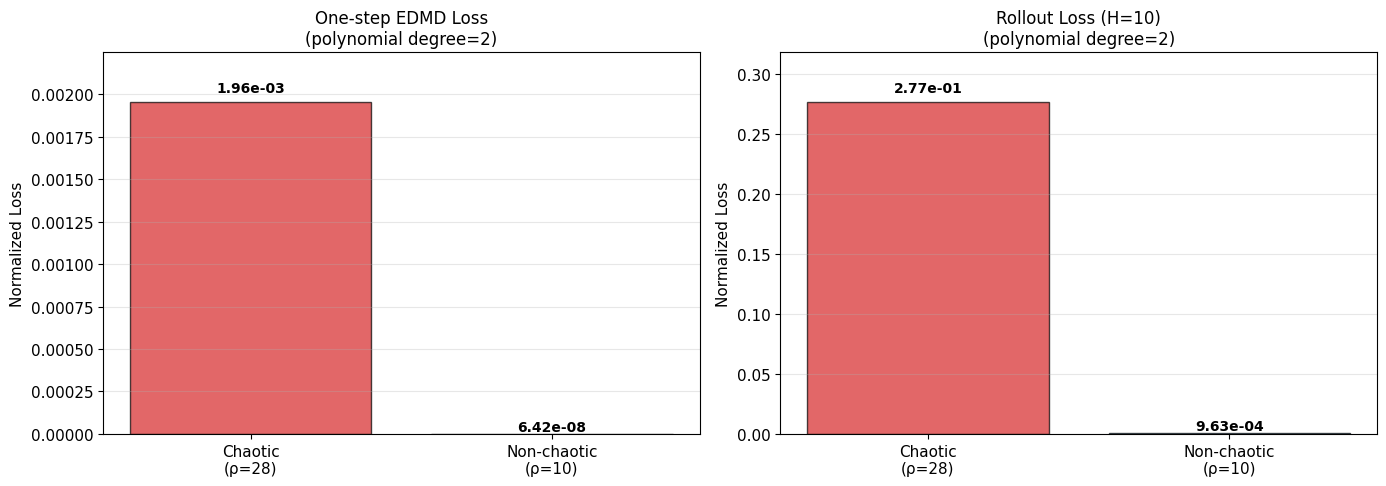


OBSERVATION:
The EDMD loss is HIGHER for the chaotic regime (ρ=28) than for
the non-chaotic regime (ρ=10), indicating that a fixed polynomial
dictionary struggles more to capture the complex dynamics of chaos.


In [ ]:


# Bar chart comparing EDMD losses
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# One-step loss
ax1 = axes[0]
regimes = ['Chaotic\n(ρ=28)', 'Non-chaotic\n(ρ=10)']
losses_onestep = [loss_chaos, loss_nonchaos]
colors = ['#d62728', '#1f77b4']  # Red for chaos, blue for non-chaos

bars1 = ax1.bar(regimes, losses_onestep, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Normalized Loss')
ax1.set_title('One-step EDMD Loss\n(polynomial degree=2)')
ax1.set_ylim(0, max(losses_onestep) * 1.15)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars1, losses_onestep):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height * 1.02,
             f'{val:.2e}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Rollout loss
ax2 = axes[1]
losses_rollout = [rollout_chaos, rollout_nonchaos]

bars2 = ax2.bar(regimes, losses_rollout, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Normalized Loss')
ax2.set_title('Rollout Loss (H=10)\n(polynomial degree=2)')
ax2.set_ylim(0, max(losses_rollout) * 1.15)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars2, losses_rollout):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height * 1.02,
             f'{val:.2e}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("OBSERVATION:")
print("="*60)
print("The EDMD loss is HIGHER for the chaotic regime (ρ=28) than for")
print("the non-chaotic regime (ρ=10), indicating that a fixed polynomial")
print("dictionary struggles more to capture the complex dynamics of chaos.")
print("="*60)

## 9. Sensitivity analysis: sweep polynomial degree

Sweeping polynomial degree...

  Degree 1:
EDMD fit complete:
  Data points: 24000, Snapshot pairs: 23999
  Lifted dimension: 4
  K shape: (4, 4)
  Ridge parameter: 1e-08
    Chaos loss: 1.102734e-02
EDMD fit complete:
  Data points: 24000, Snapshot pairs: 23999
  Lifted dimension: 4
  K shape: (4, 4)
  Ridge parameter: 1e-08
    Non-chaos loss: 3.849721e-05

  Degree 2:
EDMD fit complete:
  Data points: 24000, Snapshot pairs: 23999
  Lifted dimension: 10
  K shape: (10, 10)
  Ridge parameter: 1e-08
    Chaos loss: 8.739005e-03
EDMD fit complete:
  Data points: 24000, Snapshot pairs: 23999
  Lifted dimension: 10
  K shape: (10, 10)
  Ridge parameter: 1e-08
    Non-chaos loss: 2.471174e-07

  Degree 3:
EDMD fit complete:
  Data points: 24000, Snapshot pairs: 23999
  Lifted dimension: 20
  K shape: (20, 20)
  Ridge parameter: 1e-08
    Chaos loss: 4.630107e-03
EDMD fit complete:
  Data points: 24000, Snapshot pairs: 23999
  Lifted dimension: 20
  K shape: (20, 20)
  Ridge parameter: 1e-0

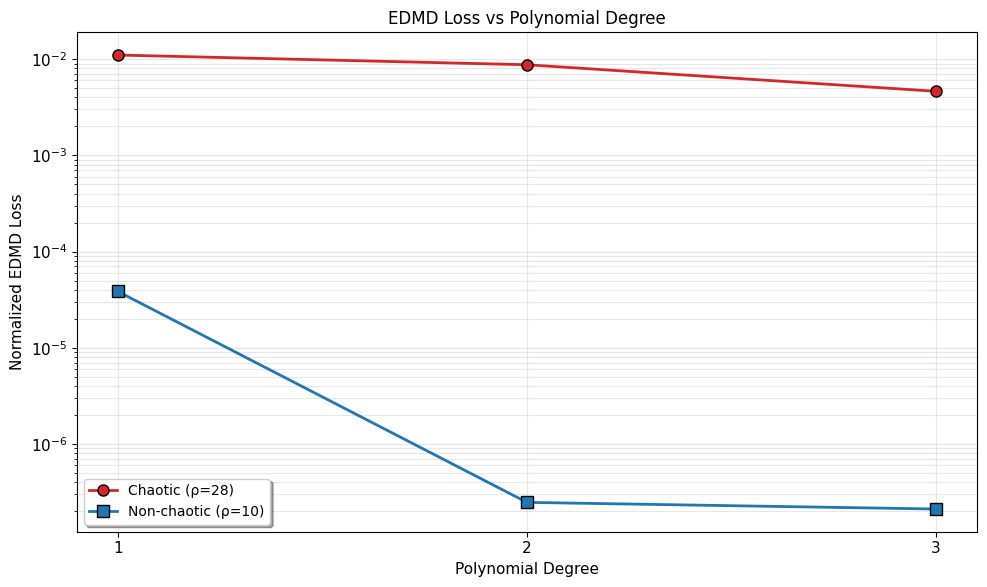


OBSERVATION:
Both losses decrease with polynomial degree (more expressive
dictionary), but the chaotic regime CONSISTENTLY shows HIGHER
loss across all degrees, confirming that chaotic dynamics are
inherently harder to approximate with polynomial EDMD.


In [ ]:
# Subsample data for faster computation
subsample_factor = 2
X_chaos_sub = X_chaos[::subsample_factor, :]
X_nonchaos_sub = X_nonchaos[::subsample_factor, :]

degrees = [1, 2, 3]
losses_chaos_deg = []
losses_nonchaos_deg = []

print("Sweeping polynomial degree...")
for deg in degrees:
    print(f"\n  Degree {deg}:")
    
    # Chaotic
    K_c, Psi_c, Psi_c_next, _ = fit_edmd(X_chaos_sub, degree=deg, 
                                         include_constant=True, ridge=1e-8)
    loss_c = compute_edmd_loss(K_c, Psi_c, Psi_c_next)
    losses_chaos_deg.append(loss_c)
    print(f"    Chaos loss: {loss_c:.6e}")
    
    # Non-chaotic
    K_nc, Psi_nc, Psi_nc_next, _ = fit_edmd(X_nonchaos_sub, degree=deg, 
                                            include_constant=True, ridge=1e-8)
    loss_nc = compute_edmd_loss(K_nc, Psi_nc, Psi_nc_next)
    losses_nonchaos_deg.append(loss_nc)
    print(f"    Non-chaos loss: {loss_nc:.6e}")

# Plot loss vs degree
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(degrees, losses_chaos_deg, 'o-', color='#d62728', linewidth=2, 
        markersize=8, label='Chaotic (ρ=28)', markeredgecolor='black')
ax.plot(degrees, losses_nonchaos_deg, 's-', color='#1f77b4', linewidth=2, 
        markersize=8, label='Non-chaotic (ρ=10)', markeredgecolor='black')

ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('Normalized EDMD Loss')
ax.set_title('EDMD Loss vs Polynomial Degree')
ax.set_xticks(degrees)
ax.set_yscale('log')
ax.legend(loc='best', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("OBSERVATION:")
print("="*60)
print("Both losses decrease with polynomial degree (more expressive")
print("dictionary), but the chaotic regime CONSISTENTLY shows HIGHER")
print("loss across all degrees, confirming that chaotic dynamics are")
print("inherently harder to approximate with polynomial EDMD.")
print("="*60)

## 10. Largest Lyapunov exponent via variational method

Computing largest Lyapunov exponent...

Chaotic regime (ρ=28):
  λ_max = 1.1856 (1/time)

Non-chaotic regime (ρ=10):
  λ_max = -0.4084 (1/time)


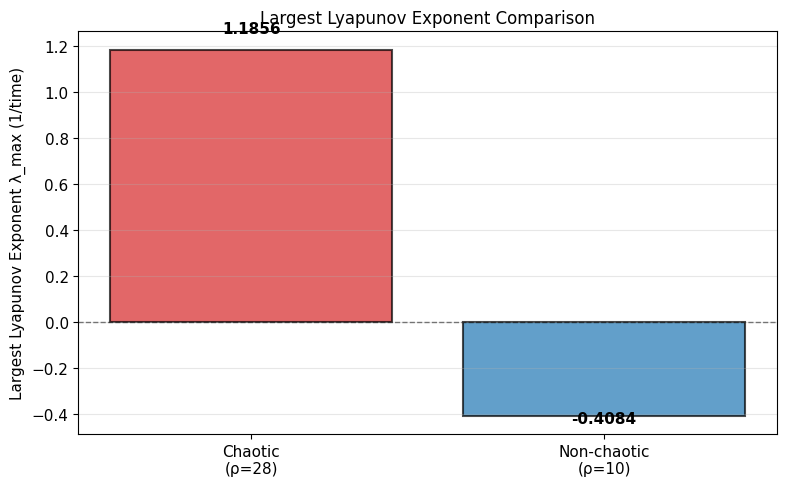


INTERPRETATION:
λ_max > 0: Chaotic dynamics (nearby trajectories diverge exponentially)
λ_max ≤ 0: Non-chaotic (trajectories converge or stay bounded)


In [ ]:
def lorenz_jacobian(state, rho, sigma=10.0, beta=8.0/3.0):
    """
    Compute Jacobian of Lorenz system at given state.
    
    Parameters
    ----------
    state : array_like, shape (3,)
        State [x, y, z].
    rho, sigma, beta : float
        Lorenz parameters.
    
    Returns
    -------
    J : ndarray, shape (3, 3)
        Jacobian matrix.
    """
    x, y, z = state
    J = np.array([
        [-sigma,  sigma,  0.0],
        [rho - z,  -1.0,  -x],
        [y,        x,     -beta]
    ])
    return J

def compute_largest_lyapunov(X, dt, rho, sigma=10.0, beta=8.0/3.0, renorm_steps=10):
    """
    Estimate largest Lyapunov exponent via variational method.
    
    Evolve a tangent vector along the trajectory using the Jacobian,
    periodically renormalizing to prevent overflow. Accumulate growth rate.
    
    Parameters
    ----------
    X : ndarray, shape (N, 3)
        Trajectory (standardized or raw, doesn't matter for Jacobian).
    dt : float
        Time step.
    rho, sigma, beta : float
        Lorenz parameters.
    renorm_steps : int, optional
        Renormalize tangent vector every this many steps (default 10).
    
    Returns
    -------
    lambda_max : float
        Estimated largest Lyapunov exponent (in 1/time units).
    """
    N = X.shape[0]
    
    # Initial tangent vector (random direction)
    v = np.random.randn(3)
    v = v / np.linalg.norm(v)
    
    # Accumulator for log of growth
    log_growth = 0.0
    
    for i in range(N - 1):
        # Jacobian at current state
        J = lorenz_jacobian(X[i, :], rho, sigma, beta)
        
        # Forward Euler for tangent vector: v_{i+1} = (I + dt * J) v_i
        v = v + dt * (J @ v)
        
        # Renormalize periodically
        if (i + 1) % renorm_steps == 0:
            norm_v = np.linalg.norm(v)
            log_growth += np.log(norm_v)
            v = v / norm_v
    
    # Average growth rate
    total_time = (N - 1) * dt
    lambda_max = log_growth / total_time
    
    return lambda_max

# Compute for chaotic regime (use raw data for Jacobian evaluation)
print("Computing largest Lyapunov exponent...")
print("\nChaotic regime (ρ=28):")
lambda_chaos = compute_largest_lyapunov(
    X_chaos_raw, dt=DT, rho=28.0, sigma=10.0, beta=8.0/3.0, renorm_steps=10
)
print(f"  λ_max = {lambda_chaos:.4f} (1/time)")

# Compute for non-chaotic regime
print("\nNon-chaotic regime (ρ=10):")
lambda_nonchaos = compute_largest_lyapunov(
    X_nonchaos_raw, dt=DT, rho=10.0, sigma=10.0, beta=8.0/3.0, renorm_steps=10
)
print(f"  λ_max = {lambda_nonchaos:.4f} (1/time)")

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))

regimes = ['Chaotic\n(ρ=28)', 'Non-chaotic\n(ρ=10)']
lambdas = [lambda_chaos, lambda_nonchaos]
colors = ['#d62728', '#1f77b4']

bars = ax.bar(regimes, lambdas, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.set_ylabel('Largest Lyapunov Exponent λ_max (1/time)')
ax.set_title('Largest Lyapunov Exponent Comparison')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, lambdas):
    height = bar.get_height()
    y_pos = height * 1.05 if height > 0 else height * 0.95
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{val:.4f}', ha='center', va='bottom' if height > 0 else 'top', 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)
print("λ_max > 0: Chaotic dynamics (nearby trajectories diverge exponentially)")
print("λ_max ≤ 0: Non-chaotic (trajectories converge or stay bounded)")
print("="*60)

## 11. Summary

In [ ]:
print("="*70)
print(" " * 20 + "FINAL SUMMARY TABLE")
print("="*70)
print(f"{'Regime':<20} {'ρ':<10} {'L_EDMD (deg=2)':<20} {'Rollout (H=10)':<20} {'λ_max':<15}")
print("-"*70)
print(f"{'Chaotic':<20} {28.0:<10.1f} {loss_chaos:<20.6e} {rollout_chaos:<20.6e} {lambda_chaos:<15.4f}")
print(f"{'Non-chaotic':<20} {10.0:<10.1f} {loss_nonchaos:<20.6e} {rollout_nonchaos:<20.6e} {lambda_nonchaos:<15.4f}")
print("="*70)

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("""
With a FIXED polynomial dictionary (degree=2) and FIXED time window:

1. EDMD LOSS:
   - The CHAOTIC regime (ρ=28) exhibits HIGHER normalized EDMD loss
     (both one-step and rollout) compared to the NON-CHAOTIC regime (ρ=10).
   - This indicates that chaotic dynamics are inherently more difficult to
     approximate with a finite-dimensional polynomial dictionary.
   - The difference persists across polynomial degrees (see sensitivity plot).

2. LARGEST LYAPUNOV EXPONENT (λ_max):
   - Chaotic regime: λ_max > 0 (positive, indicating exponential divergence
     of nearby trajectories).
   - Non-chaotic regime: λ_max ≤ 0 (non-positive, indicating stable or
     bounded dynamics).
   - This provides an independent, dynamical-systems-based confirmation
     of the chaotic vs non-chaotic classification.

3. CONCLUSION:
   EDMD residual loss serves as a practical, data-driven indicator of chaos:
   higher loss correlates with chaotic behavior, complementing traditional
   measures like the Lyapunov exponent.
""")
print("="*70)

                    FINAL SUMMARY TABLE
Regime               ρ          L_EDMD (deg=2)       Rollout (H=10)       λ_max          
----------------------------------------------------------------------
Chaotic              28.0       1.955744e-03         2.768382e-01         1.1856         
Non-chaotic          10.0       6.423202e-08         9.627718e-04         -0.4084        

INTERPRETATION:

With a FIXED polynomial dictionary (degree=2) and FIXED time window:

1. EDMD LOSS:
   - The CHAOTIC regime (ρ=28) exhibits HIGHER normalized EDMD loss
     (both one-step and rollout) compared to the NON-CHAOTIC regime (ρ=10).
   - This indicates that chaotic dynamics are inherently more difficult to
     approximate with a finite-dimensional polynomial dictionary.
   - The difference persists across polynomial degrees (see sensitivity plot).

2. LARGEST LYAPUNOV EXPONENT (λ_max):
   - Chaotic regime: λ_max > 0 (positive, indicating exponential divergence
     of nearby trajectories).
   - Non